In [1]:
#%matplotlib nbagg
import numpy as np
import pandas as pd 
import scipy as sp

from scipy import linalg as lg
from scipy import integrate
from scipy import stats
from scipy.optimize import curve_fit
from scipy.spatial import distance

import iminuit
from iminuit import Minuit, describe, Struct

import string
import sys

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
plt.style.use('classic') 

# Constants and unities: time (sec), dist(Km)

In [2]:
#Everything to Km and sec
Km = 1
seg= 1
pc = 3.0857e13*Km
Mpc= 1e6*pc 

#The values for Plank come from: https://arxiv.org/pdf/1807.06209.pdf
#The values for Riess come from: https://arxiv.org/pdf/1604.01424v3.pdf
h  = 0.674                           #h of Hubble (Plank) H0=100*h
H0 = 100*h*Km/(seg*Mpc)              #H0 Plank
H0_err = 0.5*Km/(seg*Mpc)            #H0 error for Planck

H0_Union = 70*Km/(seg*Mpc)           #H0 Union2.1 
#H0_Riess = 73.5*Km/(seg*Mpc)         #H0 Riess
#H0_errR = 1.4*Km/(seg*Mpc)
H0_Riess = 73.24*Km/(seg*Mpc)         #H0 Riess
H0_errR = 1.59*Km/(seg*Mpc)  

Ok = 0                               #Omega k, assuming a flat universe
Om = 0.315                           #Omega matter
Ol = 1 - Om - Ok                     #Omega lambda
f  = Om**0.55                        #growth factor

C  = 299792458e-3*Km/seg             #speed of the light Km/seg
ly = 9.461e12*Km                     #light year
conv = np.pi/180                     #degree to radians 

print('The age of the Universe is',H0**(-1)/(3600*24*365)*1e-6, 'Millions of years')

The age of the Universe is 14517.344973932104 Millions of years


# Distances in cosmology 

In [3]:
#Comovil distance
def Dist_com(z, O_matter=Om, O_k=Ok, H_Hubble=H0):
    if type(z)==float: z = np.array([z])
    dist_com = np.array([C*sp.integrate.quad(lambda z:1/( (O_matter*(1+z)**3 + O_k*(1+z)**2 + (1-O_matter-O_k) )**0.5 ), 0, zi)[0]/H_Hubble for zi in z])
    return dist_com


#Diameter angular distance (or physical distance when Ok=0) 
def Dist_ang(z, O_matter=Om, O_k=0, H_Hubble=H0):
    a = 1/(1 + z)
    dist_ang = Dist_com(z, O_matter, O_k, H_Hubble)*a
    return dist_ang


#Luminosity distance D_l with z
def Dist_lz(z, O_matter=Om, O_k=0, H_Hubble=H0):
    a = 1/(1 + z)
    dist_lum = Dist_com(z=z, O_matter=O_matter, O_k=O_k, H_Hubble=H_Hubble)/a
    return dist_lum


#Luminosity distance unsing the distance modulus, we convert from pc to Km.
#mu_shift is the correction in the luminosity distance due to the use of one or another value of H0
#(Union2.1 uses H=H_Union for the distance modulus)
#H_Hubble is the H0 we want to get, H_2 is the Hubble constant of the data set we have
def Dist_lm(mu, shift=False, H_Hubble=H0, H_2=H0_Union):
    if shift:
        mu_shift = 5*np.log10(H_2/H_Hubble)
        mu_corr  = np.array(mu) - mu_shift
        dist_lum = 10**(mu_corr/5 + 1) 
    else: dist_lum = 10**(np.array(mu)/5 + 1)
    return dist_lum*pc

# Radial velocity (peculiar) and the Hubble flow 

In [4]:
#Calculating the component of the velocity that we can see (radial) 
#this is based on "Hubble bubble or Hubble bubble" 
#Dl is the value calculated with the distance modulus, Dl_ the one calculated with z (Homogeneous).
def vel(Dl, z, O_matter=Om, O_k=Ok, H_Hubble=H0):
    Dl_ = Dist_lz(z=z,O_matter=O_matter, O_k=O_k, H_Hubble=H_Hubble)
    return -C*np.array(z)*( np.array(Dl)/np.array(Dl_) - 1)


#The Hubble flow
def Vel_Hubble_flow(z, O_matter=Om, O_k=Ok, H_Hubble=H0):
    return H_Hubble*Dist_ang(z=z, O_matter=O_matter, O_k=O_k, H_Hubble=H_Hubble)

# Statistics

In [5]:
#Error in the distance computed using the distance modulus
#Dis_ is the distance computed with the distance modulus and Err_ is the error in the distance modulus
def Err_dist_mod(Dis_, Err_):
    error_Dl = np.log(10)*np.array(Dis_)*np.array(Err_)/5               
    return np.array(np.absolute(error_Dl))


#Weighted average
#This formula is derived from the Likelihood method for a data ("data") where each x_i follows a
#gaussian destribution with a different error ("Errs") for each x_i
def Weighted_mean(data, Errs):
    data = np.array(data)
    Errs = np.array(Errs)
    weighted_mean = np.sum(data/Errs**2)/(np.sum(Errs**(-2)))
    return weighted_mean


#Weighted standar deviation
#This formula is derived from the Likelihood method for a data where each x_i follows a
#gaussian destribution with a different error ("Errs") for each x_i
#I guess this formula is good for large number of elements to average
def Weighted_std(Errs):
    Errs = np.array(Errs)
    weighted_var = 1/np.sum(1/Errs**2)
    return np.sqrt(weighted_var)


#Error in the radial velocitie (model)
#H_err is the error in the Hubble parameter
#H_Hubble is the Hubble parameter
#modD is the distance modulus and modDE is its error
def Error_Vr(modD, modDE, H_Hubble=H0, H_2=H0_Union, H_err=H0_err, shift=False, Include_H0_err=True):
    modD = np.array(modD)
    modDE = np.array(modDE)
    
    #Error in the distance computed using de distance modulus.
    Err_dist_mu = Err_dist_mod(Dis_= Dist_lm(mu=modD, shift=shift, H_Hubble=H_Hubble, H_2=H_2), Err_=modDE)
    Dl_mu = Dist_lm(mu=modD, shift=shift, H_Hubble=H_Hubble, H_2=H_2)
    
    #This formula for the error is calculated by using the aproximation dl=cz/H0
    if Include_H0_err: return np.sqrt( (H_Hubble*Err_dist_mu)**2 + (Dl_mu*H_err)**2 )
    else: return np.absolute(H_Hubble*Err_dist_mu)
    
#Error in V calculated directly from the error in the inhomogeneous distance D.    
def Error_Vr_DE(DE, Dhom, z):
    return C*z*DE/Dhom 

#Dnh is the luminosity distance from GW  for a non-homogenious universe
#eDnh is the error in the luminosity distance for a non-homoginious universe
def Error_GWVr(Dnh, eDnh, Include_H0_err=True, H_Hubble=H0, H_err=H0_err):
    #This formula for the error is calculated by using the aproximation dl=cz/H0
    if Include_H0_err: return np.sqrt( (H_Hubble*eDnh)**2 + (Dnh*H_err)**2 )
    else: return np.absolute(H_Hubble*eDnh)
    
    
#Chi² for a lineal model y=ax+b.
#data_x and data_y are the data in the x and y axis respectively.
#a0 and b0 are initial guess for the parameters a and b.
#limits are the ranges in which a and b will be found, if no list is passed 
#the limits will be assumed to be (-1,1) for each parameter. The list has
#the structure limits=[(inf_a, sup_a),(inf_b,sup_b)].
#error_x and error_y are the errors in each of the axis x and y. If there're not errors
#then the minimization will be done without weights. 
def chi2_lineal_minuit(data_x, data_y, a0, b0, error_x=False, error_y=False, limits=False, fix_a=False, fix_b=False, print_level=0, minos=False):
    ##################################################################
    ##################################################################
    #Assigning errors as weights for the chi2_func function
    #this set of "if's" conditionals is to make sure that there's
    #always a weight for the chi2_func function    
    if type(error_x)==bool or type(error_y)==bool:
        #If only one is boolean there's error only for x or y:  
        if type(error_x)==bool: errX = np.zeros_like(data_x)
        else: errX = error_x
            
        if type(error_y)==bool: errY = np.zeros_like(data_y)
        else: errY = error_y
    
    #If no one is boolean
    else: 
        errX = error_x
        errY = error_y
        
    #If both are boolean theres not errors
    if type(error_x)==bool and type(error_y)==bool:
        errX = np.ones_like(data_x)
        errY = np.zeros_like(data_y)
        
    #Defining the chi2 function for a lineal model   
    def chi2_func(a,b):
        model_ = a*data_x + b
        chi2 = np.sum( (data_y - model_)**2/np.sqrt(errX**2 + errY**2)**2 )
        return chi2 
    
    ##################################################################
    ##################################################################
    #The limits for the parameters a and b
    if limits:
        inf_a = limits[0][0]
        sup_a = limits[0][1]
        inf_b = limits[1][0]
        sup_b = limits[1][1]
    else:
        inf_a = -1
        sup_a = 1
        inf_b = -1
        sup_b = 1
    
    #Minimizing chi2_func using minuit
    result_minuit = Minuit(chi2_func, a=a0, error_a=0.1, limit_a=(inf_a,sup_a), fix_a=fix_a,
                                      b=b0, error_b=0.1, limit_b=(inf_b,sup_b), fix_b=fix_b,
                                      errordef=1, print_level = print_level)
    result_minuit_mingrad = result_minuit.migrad()
    
    if minos:
        result_minuit.minos();
        result_minuit.print_param()
        
    #The values of the parameters and their errors
    a = result_minuit.values[0]
    b = result_minuit.values[1]
    aE = result_minuit.errors[0]
    bE = result_minuit.errors[1]
    
    #The chi2 minimal value
    chi2_min = chi2_func(a,b)
    print("The minimize X² is =", chi2_min)
    
    return [(a,aE),(b,bE)]

# Shells

In [6]:
##############################################################################################################
##############################################################################################################
#This function calculate the shells for a list "data"
#If limits=True then it must be passed a list "bounds" wiht the limits.
#If n is an integer then it will build up n shells, if it is a float
#it will be the thickness of the shell in the same unities as "data".
def Shells_simple(Data, n, limits=False, bounds=None):
    Data = np.array(Data)
    
    #Determining if it is any interval to build the shells
    if limits:
        d_min = bounds[0]
        d_max = bounds[1]
    else:
        d_min = 0
        d_max = max(Data)  
    
    #The step
    if type(n)==int: 
        step = (d_max - d_min)/n
        #print('int',step)
    else:
        step = n
        #print('float',step)
        
    #List to save the boolean list for each shell and the distance per shell
    shell_idx = list()
    shell_dist = list()
    
    #Building the shells
    d_lim = d_max
    dist=0.0
    while dist < d_lim:
        dist = d_min + step
        idx_shell = (d_min<Data) & (dist>Data)
        if len(Data[idx_shell]) !=0:
            shell_idx.append(idx_shell)
            shell_dist.append(Data[idx_shell])
        d_min = dist
    #print('Shells=',len(shell_idx))
    return [shell_idx, shell_dist, len(shell_idx)]

# Plots

In [50]:
#Plots
#This function makes the plots for the fits
#"zs" is a list with the redshift
#"mu" is a list with the distance modulus
#"muE" is a list with the error for the distance modulus
#"zsup" is the maximal redshift we are using
#"dh" is the value for the average density contrast
#"dhE" the error for the average density contrast
#"zlim" the zlim
#"zlimE" the error for zlim
#"H_Hubble" is the Hubble constant we want to use
#"H_2" is the Hubble constant of the data set we are working
#if "shift" is set to "True" then the data set transforms from H_2 to H_Hubble, if it is set to "False" then we work with the Hubble constant of the data set
#"GW" is a dictionary with the neede info for the Gravitational Waves. 
#"name plot" is the name we want to give to the plot
#"shells", whether we want to make the plot for shells or not
#"n", if shells=True, then n is the thickness of the shell in "z" unities or the number of shells we want to create
#"errorBar" True if want to plot the error bars
#"text_plot" the text we want to add to the plot
#"v_line" to add the vertical line which shows the value of zlim
#"plot_title" the title we want to give to the plot
#"figs" if we want to give to make a plot each time we use this function. 
def PlotFitData_zv(zs, mu, muE, zsup, dh, dhE, zlim, zlimE, H_Hubble, H_2, H_error, O_m, O_mE, CFM, DE=False, contour_plot_dic=False, GW=False, name_plot=False, shift=False, shells=False, n=0.004, errorBar=False, text_plot=False, legend=True, v_line=True, plot_title=False, figs=False):
    zs  = np.array(zs)
    mu  = np.array(mu)
    if type(DE)==type(np.array([])): DE=np.array(DE)
    else: muE=np.array(muE)
    
    if shells: 
        #Building up the shells
        shell_id = Shells_simple(Data=zs, n=n, limits=True, bounds=[0, zsup])[0]
        
        #Luminosity distance: Dlh->homogeneous, Dlnh->Nonhomogeneous
        #Error in the luminosity distance with mu (DlnhE) and with z (DlhE) 
        Dlh   = Dist_lz(z=zs, H_Hubble=H_Hubble, O_matter=O_m)
        Dlnh  = Dist_lm(mu=mu, shift=shift, H_Hubble=H_Hubble, H_2=H_2)
        DlhE  = (C*zs*H_error/H_Hubble**2)
        if type(DE)==type(np.array([])):DlnhE=DE
        else:DlnhE = Err_dist_mod(Dis_=Dlnh, Err_=muE)
        
        #Dlh and Dlnh and their errors, for the shells
        zs   = np.array([np.mean(zs[shell_i]) for shell_i in shell_id])
        Dlh  = np.array([Weighted_mean(data=Dlh[shell_i],  Errs=DlhE[shell_i])  for shell_i in shell_id])
        Dlnh = np.array([Weighted_mean(data=Dlnh[shell_i], Errs=DlnhE[shell_i]) for shell_i in shell_id])
        DlhE = np.array([Weighted_std(Errs=DlhE[shell_i])  for shell_i in shell_id])
        DlnhE= np.array([Weighted_std(Errs=DlnhE[shell_i]) for shell_i in shell_id])
        
        #Velocities and their errors
        vs  = vel(Dl=Dlnh, z=zs, H_Hubble=H_Hubble, O_matter=O_m)/C
        vsE = Error_Vr(modD=mu, modDE=muE, H_Hubble=H_Hubble, H_2=H_2, H_err=H_error, shift=shift, Include_H0_err=True)/C
        vsE = np.array([ Weighted_std(Errs=vsE[shell_i]) for shell_i in shell_id ])
        
        if type(DE)==type(np.array([])):vsE = Error_Vr_DE(DE=DlnhE, Dhom=Dlh, z=zs)/C 
        else:                             
            vsE = Error_Vr(modD=mu, modDE=muE, H_Hubble=H_Hubble, H_2=H_2, H_err=H_error, shift=shift, Include_H0_err=True)/C             
            vsE = np.array([ Weighted_std(Errs=vsE[shell_i]) for shell_i in shell_id ])  
            
        
    
        #Zones: inside and outside the homogeneity
        id_zone1 = zs<zlim
        id_zone2 = zs>zlim
           
    else:
        #Data for the fit
        id_zsup = zs<zsup
        zs = zs[id_zsup]
        mu = mu[id_zsup]
        if type(DE)==type(np.array([])): DE=DE[id_zsup]
        else: muE= muE[id_zsup]
        
    
        #Luminosity distance: Dlh->homogeneous, Dlnh->Nonhomogeneous
        #Error in the luminosity distance with mu (DlnhE) and with z (DlhE) 
        Dlh   = Dist_lz(z=zs, H_Hubble=H_Hubble, O_matter=O_m)
        Dlnh  = Dist_lm(mu=mu, shift=shift, H_Hubble=H_Hubble, H_2=H_2)
        DlhE  = (C*zs*H_error/H_Hubble**2)
        if type(DE)==type(np.array([])):DlnhE=DE
        else:DlnhE = Err_dist_mod(Dis_=Dlnh, Err_=muE)
       
        #Velocities and their errors
        vs  = vel(Dl=Dlnh, z=zs, H_Hubble=H_Hubble, O_matter=O_m)/C
        vsE = Error_Vr(modD=mu, modDE=muE, H_Hubble=H_Hubble, H_2=H_2, H_err=H_error, shift=shift, Include_H0_err=True)/C
        
        if type(DE)==type(np.array([])):vsE = Error_Vr_DE(DE=DlnhE, Dhom=Dlh, z=zs)/C 
        else:                           vsE = Error_Vr(modD=mu, modDE=muE, H_Hubble=H_Hubble, H_2=H_2, H_err=H_error, shift=shift, Include_H0_err=True)/C
    
        #Zones: inside and outside the homogeneity
        id_zone1 = zs<zlim
        id_zone2 = zs>zlim
    
    
    #Data for the plot of the fit
    z_z1 = np.linspace(min(zs)-min(zs)/3, zlim, 100)       #for zone number 1 
    z_z2 = np.linspace(zlim, max(zs)+max(zs)/50, 100)      #for zone number 2
    d_z1 = Dist_lz(z=z_z1, H_Hubble=H_Hubble, O_matter=O_m)/Mpc
    d_z2 = Dist_lz(z=z_z2, H_Hubble=H_Hubble, O_matter=O_m)/Mpc

    
    #Plot
    if figs:fig=plt.figure(figsize=(8,8))
    
    if contour_plot_dic: ax=plt.subplot(121)
    else: ax=plt.subplot(111)
    
    z1 = CFM['z1']
    color1=z1['color']
    marker1 =z1['marker']
    
    z2= CFM['z2']
    color2=z2['color']
    marker2= z2['marker']
    
    
    Eb = CFM['Eb']
    colorEb=Eb['color']
    markerEb=Eb['marker']
    markerEbColor=Eb['markerfacecolor']
    fmtEb=Eb['fmt']
    
    Vl = CFM['Vl']
    colorVl =Vl['color']
    
    #Plot for the fit
    if legend:
        if O_m==Om: ax.plot(z_z1, -(f/3)*dh*z_z1,  marker1, color=color1, linewidth=1.5, alpha=5, label='$\delta_v=%.4f \pm %.4f$\n$z_{v}=%.4f \pm %.4f$\n$\Omega_m=%.3f$' %(dh, dhE, zlim, zlimE, O_m) )
        else: ax.plot(z_z1, -(f/3)*dh*z_z1,  marker1, color=color1,       linewidth=1.5, alpha=5, label='$\delta_v=%.4f \pm %.4f$\n$z_{v}=%.4f \pm %.4f$\n$\Omega_m=%.4f \pm %.4f$' %(dh, dhE, zlim, zlimE, O_m, O_mE ) )
        ax.plot(z_z2, -(f/3)*dh*zlim**3/z_z2**2 , marker2, color=color1, linewidth=1.5, alpha=5)
    else:
        ax.plot(z_z1, -(f/3)*dh*z_z1,  marker1, color=color1, linewidth=1.5, alpha=5) #,label=r'$\bar \delta=0$')
        ax.plot(z_z2, -(f/3)*dh*zlim**3/z_z2**2, marker2, color=color1, linewidth=1.5, alpha=5)
    
        
    #Plot for the data
    font = {
            'family': 'Courier New',
            'color':  'black',
            'weight': 'normal',
            'size': 30}
    
    font_legend = {
            'family': 'Courier New',
            'weight': 'normal',
            'size': 19}
    
    font_text = {
            'family': 'Courier New',
            'color':  color1,
            'weight': 'normal',
            'size': 22}
    
    #Plot for the GW
    if GW:
        EbGW             = CFM['EbGW']
        colorEb_GW       = EbGW['color']
        markerEb_GW      = EbGW['marker']
        markerEbColor_GW = EbGW['markerfacecolor']
        fmtEb_GW         = EbGW['fmt']
        GW_idx           = GW['GW_z']<zsup
        
        font_GW = {
            'family': 'Courier New',
            'color':  colorEb_GW,
            'weight': 'normal',
            'size': 15
                 }
        
        if shells:
            Zs_GW = GW['GW_z'][GW_idx]
            Dlnh_GW = GW['GW_dl'][GW_idx]
            DlnhE_GW = GW['GW_dlE'][GW_idx]
            names_GW = GW['GW_names'][GW_idx]
            
            #Building the shells for the GWs
            shell_idGW = Shells_simple(Data=Zs_GW, n=n, limits=True, bounds=[0, zsup])
            Zs_GW    = np.array([np.mean(Zs_GW[shell_i]) for shell_i in shell_idGW[0]])
            Dlnh_GW  = np.array([Weighted_mean(data=Dlnh_GW[shell_i], Errs=DlnhE_GW[shell_i]) for shell_i in shell_idGW[0]])
            DlnhE_GW = np.array([Weighted_std(Errs=DlnhE_GW[shell_i]) for shell_i in shell_idGW[0]])
            names_GW = np.array([names_GW[shell_i] for shell_i in shell_idGW[0] ])
           
            #Velocities and their errors
            vs_GW  = vel(Dl=Dlnh_GW, z=Zs_GW, H_Hubble=H_Hubble, O_matter=O_m)/C
            vsE_GW = Error_GWVr(Dnh=Dlnh_GW, eDnh=DlnhE_GW, H_Hubble=H_Hubble, H_err=H_error)/C
            #vsE_GW = np.array([ Weighted_std(Errs=vsE_GW[shell_i]) for shell_i in shell_idGW[0]])/C
            

            #The plot
            if errorBar:
                for i in range(len(names_GW)):
                    for j in range(len(names_GW[i])):
                        ax.errorbar(x=[Zs_GW[i]], y=[vs_GW[i]], yerr=[vsE_GW[i]], fmt=fmtEb_GW, ecolor=colorEb_GW, alpha=0.5, capthick=1, markeredgewidth=1.2, marker=markerEb_GW, mfc=markerEbColor_GW, markersize=16)  
                        ax.text(Zs_GW[i]+Zs_GW[i]/40, vs_GW[i]-vs_GW[i]/(j+0.6), r'$%s$'%names_GW[i][j], fontdict=font_GW)
        
        
        else:
            Zs_GW = GW['GW_z'][GW_idx]
            Dlnh_GW = GW['GW_dl'][GW_idx]
            DlnhE_GW = GW['GW_dlE'][GW_idx]
            names_GW = GW['GW_names'][GW_idx]
            
            #Velocities and their errors
            vs_GW  = vel(Dl=Dlnh_GW, z=Zs_GW, H_Hubble=H_Hubble, O_matter=O_m)/C
            vsE_GW = Error_GWVr(Dnh=Dlnh_GW, eDnh=DlnhE_GW, H_Hubble=H_Hubble, H_err=H_error)/C
            
            #The plot
            if errorBar:
                for i in range(len(Zs_GW)):
                    ax.errorbar(x=[Zs_GW[i]], y=[vs_GW[i]], yerr=[vsE_GW[i]], fmt=fmtEb_GW, ecolor=colorEb_GW, alpha=0.5, capthick=1, markeredgewidth=1.2, marker=markerEb_GW, mfc=markerEbColor_GW, markersize=16)
                    ax.text(Zs_GW[i]+Zs_GW[i]/40, vs_GW[i]-vs_GW[i]/(i+0.6), r'$%s$'%names_GW[i], fontdict=font_GW)
   
    if errorBar: ax.errorbar(x=zs, y=vs, yerr=vsE, fmt=fmtEb, ecolor=colorEb, alpha=0.5, capthick=1, markeredgewidth=1.2, marker=markerEb, mfc=markerEbColor, markersize=1.2)      
    if text_plot: ax.text(x=text_plot['x'], y=text_plot['y'], s=text_plot['text'], fontdict=font_text)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
    if v_line: ax.vlines(x=zlim, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color=colorVl, linewidth=1.5)
        
    ax.set_xlabel('z', fontdict=font)  
    ax.set_ylabel('$\\frac{v_r}{c}$', fontdict=font, rotation=0)
    ax.set_xlim(min(z_z1), max(z_z2))
    if plot_title: ax.set_title(plot_title, fontdict=font)
    plt.legend(loc='best', fancybox=True, shadow=True, prop=font_legend,frameon=False, numpoints =1)
    
    if contour_plot_dic:
        ax = plt.subplot(122)
        fit_minuit = contour_plot_dic['Fit']
        par1 = contour_plot_dic['par1']
        par2 = contour_plot_dic['par2']
        fit_minuit.draw_contour(par1, par2,  bound=4, show_sigma=True)
        
        if par1=='zlim': par1='$z_v$'
        if par2=='dh': par2='$\delta_v$'
        ax.set_xlabel(par1, fontdict=font)
        ax.set_ylabel(par2, fontdict=font, rotation=0)
        
        plt.grid(False)
     
    if name_plot: plt.savefig('/home/brayan/Documentos/Universidad/Proyecto_de_grado/Figures/Fit_V/%s'%name_plot)

    return None

# Redshift correction with 2M++

In [8]:
def zCorrection(tmppCoords, tmppV, SN_z, SN_RAC, SN_DEC, zCorr=False, method='mean', O_m=Om, O_k=Ok, H_Hubble=H0, crit=True):
    #If you don't wanna do the redshift correction just set zCorr=False
    if zCorr==False: return [np.ones_like(SN_z, dtype=bool) , np.zeros_like(SN_z)]
    
    #If you want to
    else:
        h = H_Hubble/100*(seg*Mpc/Km)
        if crit: crit=(400/256)*Mpc/h
        else: crit=crit
    
        #For 2M++ the coordinates are cartesian galactic comovil
        #Now we just take those galaxies within a radio of 200/h Mpc
        R_tmpp = np.linalg.norm(tmppCoords/h, axis=1)
        idxR_tmpp200h = 200.0/h > R_tmpp
        tmppCoords = tmppCoords[idxR_tmpp200h]*Mpc/h
        tmppV = tmppV[idxR_tmpp200h]

        #SNs
        d_com = Dist_com(z=SN_z, H_Hubble=H_Hubble, O_matter=O_m, O_k=O_k)
        coors_icrs_SN = SkyCoord(ra=SN_RAC*u.deg, dec=SN_DEC*u.deg, distance=d_com*u.km, frame='icrs')
        coors_gala_SN = coors_icrs_SN.transform_to('galactic')

        #Cartesian coordinates for the SN in galactic coordinates
        XYZ_SN = np.array(coors_gala_SN.cartesian.get_xyz()).T


        #Comparing SN and tmpp
        SN_idx = []
        Vtmpp  = []
        Ctmpp  = []
        for i in range(len(XYZ_SN)):
            idx_crit = (abs(XYZ_SN[i][0]-tmppCoords.T[0])<crit) & (abs(XYZ_SN[i][1]-tmppCoords.T[1])<crit) & (abs(XYZ_SN[i][2]-tmppCoords.T[2])<crit) 
            if len(tmppCoords[idx_crit])==0: 
                SN_idx.append(False)
                Vtmpp.append(False)
                Ctmpp.append(False)
            else: 
                SN_idx.append(True)
                Vtmpp.append(tmppV[idx_crit])
                Ctmpp.append(tmppCoords[idx_crit])

        SN_idx = np.array(SN_idx)
        Vtmpp  = np.array(Vtmpp)
        Ctmpp  = np.array(Ctmpp)

        #The redshift correction is V_tmpp/c
        if method=='mean':
            return [SN_idx, np.array([np.average(Vtmpp_i) for Vtmpp_i in Vtmpp[SN_idx]])/C ]
            #return [SN_idx, XYZ_SN, np.array(Ctmpp), np.array([np.average(Vtmpp_i) for Vtmpp_i in Vtmpp])/C ]

        if method=='closest':
            zCclosest = []
            for i in range(len(XYZ_SN[SN_idx])):
                if SN_idx[SN_idx][i]:
                    closestId = Closest_point(list_coor=Ctmpp[SN_idx][i], point=XYZ_SN[SN_idx][i])
                    zCclosest.append( (Vtmpp[SN_idx][i])[closestId]/C )
            return [SN_idx, np.array(zCclosest)]
            #return [SN_idx, XYZ_SN, np.array(Ctmpp), Vtmpp ,np.array(zCclosest)]

        if method=='All':  
            return [SN_idx, XYZ_SN, Ctmpp, Vtmpp/C]

# Another functions

In [9]:
################################################arctang function##################################################
#it returns the arctan(y/x) taken into account the quadrant in which the point is. It returns the angle in radians
#for the spesial point (0,0) it returns angle=0 radians
def arctanInt(x,y):
    #Idx for the coordinates
    idx = np.array(range(len(x)))
    
    #Computing the normal arctan
    arctan = np.arctan(y/x)
    
    #Choosing the quadrant
    quadrant1 = (0<x) & (0<y)
    quadrant2 = (0>x) & (0<y)
    quadrant3 = (0>x) & (0>y)
    quadrant4 = (0<x) & (0>y)
    
    #Idx for those points in each quadrant
    idxq1 = idx[quadrant1]
    idxq2 = idx[quadrant2]
    idxq3 = idx[quadrant3]
    idxq4 = idx[quadrant4]
    
    #Spesial points
    X0_Yn = (0==np.array(x)) & (0>y)                #x=0 and y<0 -> angle=270 degrees
    Xn_Y0 = (0>x) & (0==np.array(y))                #x<0 and y=0 -> angle=180 degrees
    X0_Y0 = (0==np.array(x)) & (0==np.array(y))     #x=0 and y=0 -> there is not angle (we define 0 degrees)
    
    #Spesial points
    id_X0_Yn = idx[X0_Yn]               
    id_Xn_Y0 = idx[Xn_Y0] 
    id_X0_Y0 = idx[X0_Y0]  
    
    #Changing the arctan for each quadrant 
    #For the first quadrant it is not necesssary make any change
    for i in idxq2:
        arctan[i] = arctan[i] + np.pi
    for j in idxq3:
        arctan[j] = arctan[j] + np.pi
    for k in idxq4:
        arctan[k] = arctan[k] + 2*np.pi 
    
    #Special points
    for l in id_X0_Yn:
        arctan[l] = 3*np.pi/2
    for m in id_Xn_Y0:
        arctan[m] = np.pi
    for n in id_X0_Y0:
        arctan[n] = 0
        
    return arctan


#This function returns a list without the Nan values in the list list_
def NoNanInf(list_):
    no_nan = [i for i in list_ if ~(np.isnan(i) or np.isinf(i)) ]
    return np.array(no_nan)


#This function returns the closest point (3D->[x_i,y_i,z_i]) to "point" in the list "list_coor"
def Closest_point(point,list_coor, idx=True):
    if idx: 
        return distance.cdist([point],np.array(list_coor)).argmin()
    else:
        return list_coor[ distance.cdist([point],np.array(list_coor)).argmin() ]


#This function returns the closest value to "value" in the list "lists_"
def Closest_value(value, list_):
    return (list_[np.absolute(value-np.array(list_)).argmin()], np.absolute(value-np.array(list_)).argmin())


#A lineal mode for the adjust
def Lineal_Model(x,a,b):
    return a*x + b

# $\hspace{8cm}$ Loading the data sets

# GW

In [10]:
GW_name = np.array(['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729', 'GW170809', 'GW170814', 'GW170817', 'GW170818', 'GW170823'])
GW_z  = np.array([0.09, 0.21, 0.09, 0.20, 0.07, 0.49, 0.20, 0.12, 0.01, 0.21, 0.35])
GW_dl = np.array([440, 1080, 450, 990, 320, 2840, 1030, 600, 40, 1060, 1940])*Mpc
GW_dlE= np.array([160, 520, 185, 435, 115, 1380, 355, 185, 11, 400, 935])*Mpc

"""
GW_dlz= Dist_lz(z=GW_z)
GW_dc = Dist_com(z=GW_z) 
GW_v  = vel(Dl=GW_dl, z=GW_z)    
GW_vE = Error_GWVr(Dnh=GW_dl, eDnh=GW_dlE)   
"""
GW_DataFrame = pd.DataFrame({'GW_names':GW_name, 
                             'GW_z': GW_z,
                             'GW_dl': GW_dl/Mpc,
                             'GW_dlE': GW_dlE/Mpc,
                             })
GW_DataFrame

,GW_names,GW_z,GW_dl,GW_dlE
0,GW150914,0.09,440.0,160.0
1,GW151012,0.21,1080.0,520.0
2,GW151226,0.09,450.0,185.0
3,GW170104,0.20,990.0,435.0
4,GW170608,0.07,320.0,115.0
5,GW170729,0.49,2840.0,1380.0
6,GW170809,0.20,1030.0,355.0
7,GW170814,0.12,600.0,185.0
8,GW170817,0.01,40.0,11.0
9,GW170818,0.21,1060.0,400.0


# 2M++

In [11]:
#tmppCoords = np.load('M2COOR.npy')
#tmppV      = np.load('VrM2.npy')

# Union 2.1

In [12]:
#This one has all the data with the error in the distance modulus and RAC & DEC.
#The distance modulus from Union2.1 has been calculated using H0=70Km/s/Mpc
vel_disp = 250*Km/seg

ACR_union = np.load('RAC_ult.npy')
DEC_union = np.load('DEC_ult.npy')
z_union  = np.load('RedZ_ult.npy')
mu_union = np.load('Dmod_ult.npy')     
muE_union = np.load('DmoE_ult.npy') + (5.0/np.log(10.0))*(vel_disp/(C*z_union))
names_union = np.load('Name_ult.npy')

#The whole data from Union2.1, they don't have RAC and DEC
names_union_full = np.load('Name_fullz.npy')
z_union_full  = np.load('ReS_fullz.npy')
mu_union_full = np.load('DMod_fullz.npy') 
muE_union_full = np.load('EDmod_fullz.npy')

#Adding GW
#names_union_full = np.concatenate( (names_union_full, GW_name) )
#z_union_full = np.concatenate( (z_union_full, GW_z) )  

print(len(DEC_union),len(ACR_union),len(z_union),len(mu_union))
print ('The maximal value for z in Union 2.1 is:', max(z_union))

288 288 288 288
The maximal value for z in Union 2.1 is: 0.196716069


# Pantheon

In [13]:
#Pantheon: https://archive.stsci.edu/prepds/ps1cosmo/index.html
#https://archive.stsci.edu/prepds/ps1cosmo/scolnic_datatable.html

#Pantheon Plank data ########################################################################################
names_pantheonP = ['zcmb', 'zhel', 'mu', 'dmu']
names_pantheonP_DE = ['zcmb', 'mu', 'DE']

#pantheonP = pd.read_csv('Pantheon_correction_Planck.txt', header=None, names=names_pantheonP, sep=' ')
pantheonP = pd.read_csv('Planck_Dl_error.txt', header=None, names=names_pantheonP_DE, sep=',')

z_pantheonP = pantheonP.zcmb.get_values()
mu_pantheonP = pantheonP.mu.get_values()

#muE_pantheonP = pantheonP.dmu.get_values()
DE_pantheonP = pantheonP.DE.get_values()

print(len(pantheonP))
#print(max(z_pantheonP))
#pantheon[0:10]

#Pantheon Riess data ########################################################################################
names_pantheonR = ['zcmb', 'zhel', 'mu', 'dmu']
names_pantheonR_DE = ['zcmb', 'mu', 'DE']

#pantheonR = pd.read_csv('Pantheon_correction_Riess.txt', header=None, names=names_pantheonR, sep=' ')
pantheonR = pd.read_csv('Riess_Dl_error.txt', header=None, names=names_pantheonP_DE, sep=',')

z_pantheonR = pantheonR.zcmb.get_values()
mu_pantheonR = pantheonR.mu.get_values()

#muE_pantheonR = pantheonR.dmu.get_values()
DE_pantheonR = pantheonP.DE.get_values()

print(len(pantheonR))
#print(max(z_pantheonR))
#pantheon[0:10]

1048
1048


# $z_{sup}$ for each fit

In [14]:
z_supPP = 0.11
z_supPR = 0.11
z_supUP = 0.11
z_supUR = 0.11

# $\hspace{6cm} $Fits for the inhomogeneity  with $v$

The model we are using here is:

\begin{equation}
v_{r}=-\frac{1}{3}f \overline \delta z
\end{equation}


with 

\begin{equation}
\overline \delta(z)=
     \left\{
     \begin{array}{lcc}
     \overline\delta_h & for & z<z_{lim} \\
     \\ d /z^{3}  &for& z>z_{lim} \\
     \end{array}
     \right.
\end{equation}

and  $d=\overline\delta_h z_{lim}^3$


In [15]:
#GW_dic=False
GW_dic = {'GW_names':GW_name, 'GW_z': GW_z, 'GW_dl': GW_dl, 'GW_dlE': GW_dlE}

In [16]:
#This function computes the fit for the piecewise function D_L.
#"zs" is a list with the redshift
#"mu" is a list with the distance modulus
#"muE" is a list with the error for the distance modulus
#"zsup" is the maximal redshift we are using
#"H_Hubble" is the Hubble constant we want to use
#"H_2" is the Hubble constant of the data set we are working
#if "shift" is set to "True" then the data set transforms from H_2 to H_Hubble, 
#if it is set to "False" then we work with the Hubble constant of the data set
#"name" is the name we want to give to that fit
#"shells", whether we want to make the fit with shells or not
#"n", if shells=True, then n is the thickness of the shell in "z" unities or the number of shells we want to create
#"initial_values" is the dictionary with initial values for Minuit {'dh0': , 'zlim0': , 'H0': , 'O_m0': }
#"errors" is the dictionary with the errors for Minuit (floats) {'dhE': , 'zlimE': , 'HE': , 'O_mE': }
#"limits" is the list with the limits of each parammeter for Minuit {'limits_dh': (,), 'limits_zlim':(,), 'limits_H':(,), 'limits_O_m':(,)}
#"fixed", is a list, we decide if we want to fix each parammeter (booleans) {'fix_dh': , 'fix_zlim': , 'fix_H': , 'fix_O_m': }
#"minos",is a list where we decide whether we want to compute the errors with minos or not (booleans)
#"print_level", what level of printing we want to get (float)
def Fit_v(zs, mu, muE, zsup, H_Hubble, H_2, H_error, GW=GW_dic, DE=False, name=False, shift=False, shells=False, n=0.004, initial_values=0, errors=0, limits=0, fixed=False, minos=False, print_level=1):
    zs=np.array(zs)
    mu=np.array(mu)
    if type(DE)==type(np.array([])): DE=np.array(DE)
    else: muE=np.array(muE)
        
    if GW:
        GW={'GW_names':GW['GW_names'][GW['GW_z']<zsup], 
            'GW_z':    GW['GW_z'][GW['GW_z']<zsup], 
            'GW_dl':   GW['GW_dl'][GW['GW_z']<zsup], 
            'GW_dlE':  GW['GW_dlE'][GW['GW_z']<zsup]}
        
    if shells:
        shell_id   = Shells_simple(Data=zs, n=n, limits=True, bounds=[0, zsup])[0]
        if GW: shell_idGW = Shells_simple(Data=GW['GW_z'], n=n, limits=True, bounds=[0, zsup])[0]
            
    else:
        #Data for the fit
        id_zsup = zs<zsup
        zs = zs[id_zsup]
        mu = mu[id_zsup]
        if type(DE)==type(np.array([])): DE=DE[id_zsup]
        else: muE= muE[id_zsup]
  
    ##############################################################################################################
    ##############################################################################################################
    #Initial values for Minuit
    try: dh0=initial_values['dh0']
    except: dh0=0
    try: zlim0=initial_values['zlim0']
    except:zlim0=0
    try: H_0=initial_values['H0']
    except: H_0=H_Hubble
    try: O_m0=initial_values['O_m0']
    except: O_m0=Om

    #errors for Minuit
    try: dhE=errors['dhE']
    except: dhE=0.01 
    try: zlimE=errors['zlimE']
    except: zlimE=0.01
    try: HE=errors['HE']
    except:HE=H_error 
    try: O_mE=errors['O_mE']
    except: O_mE=0
    
    #limits for Minuit
    try: limits_dh=limits['limits_dh']
    except: limits_dh=(-1,1) 
    try: limits_zlim=limits['limits_zlim']
    except: limits_zlim=(0, zsup)
    try: limits_H=limits['limits_H']
    except: limits_H=(1e-19, 1e-17)
    try: limits_O_m=limits['limits_O_m']
    except: limits_O_m=(0,1)
        
    #fixed parameters for Minuit
    try: fix_dh=fixed['fix_dh']
    except: fix_dh=False
    try: fix_zlim=fixed['fix_zlim']
    except: fix_zlim=False
    try: fix_H=fixed['fix_H']
    except: fix_H=True
    try: fix_O_m=fixed['fix_O_m']
    except: fix_O_m=True

    ##############################################################################################################
    ##############################################################################################################
    def chi2(dh, zlim, O_m, H):
        Zs = zs
        
        #Luminosity distance: Dlh->homogeneous, Dlnh->Nonhomogeneous
        #Error in the luminosity distance with mu (DlnhE) and with z (DlhE) 
        Dlh   = Dist_lz(z=Zs, H_Hubble=H, O_matter=O_m)
        Dlnh  = Dist_lm(mu=mu, shift=shift, H_Hubble=H, H_2=H_2)
        DlhE  = C*Zs*H_error/H**2
        if type(DE)==type(np.array([])):DlnhE=DE
        else:DlnhE = Err_dist_mod(Dis_=Dlnh, Err_=muE)
      
        if shells:
            #Dlh and Dlnh and their errors, for the shells
            Zs   = np.array([np.mean(Zs[shell_i]) for shell_i in shell_id])
            Dlh  = np.array([Weighted_mean(data=Dlh[shell_i],  Errs=DlhE[shell_i])  for shell_i in shell_id])
            Dlnh = np.array([Weighted_mean(data=Dlnh[shell_i], Errs=DlnhE[shell_i]) for shell_i in shell_id])
            DlhE = np.array([Weighted_std(Errs=DlhE[shell_i])  for shell_i in shell_id])
            DlnhE = np.array([Weighted_std(Errs=DlnhE[shell_i]) for shell_i in shell_id])
            
        #Velocities and their errors
        vs = vel(Dl=Dlnh, z=Zs, H_Hubble=H, O_matter=O_m)
        if type(DE)==type(np.array([])):  vsE = Error_Vr_DE(DE=DlnhE, Dhom=Dlh, z=Zs) 
        else:                             vsE = Error_Vr(modD=mu, modDE=muE, H_Hubble=H, H_2=H_2, H_err=H_error, shift=shift, Include_H0_err=True)             
        if shells & ~(type(DE)==type(np.array([]))):vsE = np.array([ Weighted_std(Errs=vsE[shell_i]) for shell_i in shell_id ])  
            
        #Zones: inside and outside the homogeneity
        id_zone1 = Zs<zlim
        id_zone2 = Zs>zlim
        
        #Linear model (zone1)
        linear_model = -(f/3)*C*dh*Zs[id_zone1]
        chi2_linear  = np.sum( ( (vs[id_zone1] - linear_model)/np.sqrt(vsE[id_zone1]**2) )**2 )
    
        #1/z³ model (zone2)
        #cubic_model = -(f/3)*C*dh*(Zs[id_zone2])*(zlim*(1+zlim))**3/(Zs[id_zone2]*(1+Zs[id_zone2]))**3
        cubic_model = -(f/3)*C*dh*zlim**3/(Zs[id_zone2])**2
        chi2_cubic  = np.sum( ( (vs[id_zone2] - cubic_model)/np.sqrt(vsE[id_zone2]**2) )**2 )
        #print('X2',chi2_linear+chi2_cubic)
        
        #Adding GW
        if GW:
            Zs_GW = GW['GW_z']
            Dlnh_GW = GW['GW_dl']
            DlnhE_GW = GW['GW_dlE']    
            
            if shells:
                #Building the shells for the GWs
                Zs_GW    = np.array([np.mean(Zs_GW[shell_i]) for shell_i in shell_idGW])
                Dlnh_GW  = np.array([Weighted_mean(data=Dlnh_GW[shell_i], Errs=DlnhE_GW[shell_i]) for shell_i in shell_idGW])
                DlnhE_GW = np.array([Weighted_std(Errs=DlnhE_GW[shell_i]) for shell_i in shell_idGW])
            
            #Zones for the GWs
            id_zone1_GW = Zs_GW<zlim
            id_zone2_GW = Zs_GW>zlim
            
            #Velocities for the GWs
            vs_GW  = vel(Dl=Dlnh_GW, z=Zs_GW, H_Hubble=H, O_matter=O_m)
            vsE_GW = Error_GWVr(Dnh=Dlnh_GW, eDnh=DlnhE_GW, H_Hubble=H, H_err=H_error, Include_H0_err=True) 
            
            #Linear model for GWs
            linear_model_GW = -(f/3)*C*dh*Zs_GW[id_zone1_GW]
            chi2_linear_GW  = np.sum( ( (vs_GW[id_zone1_GW] - linear_model_GW)/(vsE_GW[id_zone1_GW]) )**2 )

            #Cubic model for the GWs
            #cubic_model_GW = -(f/3)*C*dh*(Zs_GW[id_zone2_GW])*(zlim*(1+zlim))**3/(Zs_GW[id_zone2_GW]*(1+Zs_GW[id_zone2_GW]))**3 
            cubic_model_GW = -(f/3)*C*dh*(Zs_GW[id_zone2_GW])*zlim**3/(Zs_GW[id_zone2_GW])**3 
            chi2_cubic_GW  = np.sum( ( (vs_GW[id_zone2_GW] - cubic_model_GW)/(vsE_GW[id_zone2_GW]) )**2 )
        
            #X² for the GW
            chi2_GW = chi2_linear_GW + chi2_cubic_GW
            
            return chi2_linear + chi2_cubic + chi2_GW
    
        else: return chi2_linear + chi2_cubic
    
    
    ##############################################################################################################
    ##############################################################################################################
    result_chi2 = Minuit( chi2, 
                          dh=dh0,     error_dh=dhE,     limit_dh=limits_dh,     fix_dh=fix_dh,
                          zlim=zlim0, error_zlim=zlimE, limit_zlim=limits_zlim, fix_zlim=fix_zlim,
                          O_m=O_m0,   error_O_m=O_mE,   limit_O_m=limits_O_m,   fix_O_m=fix_O_m,
                          H=H_0,      error_H=HE,       limit_H=limits_H,       fix_H=fix_H, 
                          errordef=1.0, print_level=print_level )
        
    result_chi2.migrad(ncall=100000)
    if minos:
        if result_chi2.migrad_ok(): result_chi2.minos(maxcall=100000);
        else: print('Migrad did not converge')
        
    ##############################################################################################################
    ############################################################################################################## 
    #Getting the results:
    if shells: 
        Shell='Shell'
        lenghData = len(shell_id)
        #Shell = 'Yes'
        
    else: 
        Shell='No shell'
        lenghData = len(zs)
        #Shell = 'No'
        
    #Homogeneous X² and X²_red
    chi2_FRW     = chi2(dh=0, zlim=0, H=H_Hubble, O_m=Om)
    chi2_FRW_red = chi2(dh=0, zlim=0, H=H_Hubble, O_m=Om)/lenghData
    
    if name: Name=name
    else: Name='No Name'
    
    
    fixed = {}
    for nfixedPar in result_chi2.list_of_vary_param():  fixed[nfixedPar]='No'
    for fixedPar  in result_chi2.list_of_fixed_param(): fixed[fixedPar] ='Yes'
        
    if result_chi2.migrad_ok(): converg='Yes'
    else: converg='No'
    
    results = {
        'Fit':result_chi2,
        'values': result_chi2.values,
        'errors':result_chi2.errors,
        'X²': result_chi2.fval,
        'X²_red':result_chi2.fval/( lenghData-len(result_chi2.list_of_vary_param()) ),
        'X²_FRW':chi2_FRW,
        'X²_FRW_red':chi2_FRW_red,
        'Points':lenghData,
        'Shell':Shell,
        'Name': Name,
        'fixed':fixed,
        'Converge':converg 
    }
    
    return results

In [17]:
initial_valuesPP_ns = {'dh0':0, 'zlim0':0.05, 'H0':H0, 'O_m0':Om}

results_PP_ns = Fit_v(zs=z_pantheonP, mu=mu_pantheonP, muE=False, name='Pantheon Plank', GW=GW_dic, DE=DE_pantheonP,
                    zsup=z_supPP, H_Hubble=H0, H_2=0, H_error=H0_err, shift=False, 
                    shells=False, n=0.004,
                    initial_values=initial_valuesPP_ns)

FCN = 223.3064390262451 
 TOTAL NCALL = 112 
 NCALLS = 112 
 
 
 EDM = 3.489890192913412e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,dh,-0.1893,0.0255455,,,-1,1,No
1,zlim,0.0558104,0.00011168,,,0,0.11,No
2,O_m,0.315,0,,,0,1,Yes
3,H,2.18427e-18,1.62038e-20,,,1e-19,1e-17,Yes


In [18]:
initial_valuesPP_nGW_ns = {'dh0':0, 'zlim0':0.05, 'H0':H0, 'O_m0':Om}

results_PP_nGW_ns = Fit_v(zs=z_pantheonP, mu=mu_pantheonP, muE=False, name='Pantheon Plank', GW=False, DE=DE_pantheonP,
                    zsup=z_supPP, H_Hubble=H0, H_2=0, H_error=H0_err, shift=False, 
                    shells=False, n=0.004,
                    initial_values=initial_valuesPP_ns)

FCN = 223.18922491042673 
 TOTAL NCALL = 83 
 NCALLS = 83 
 
 
 EDM = 0.0001415605073432619 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,dh,-0.188792,0.0255495,,,-1,1,No
1,zlim,0.05581,0.000118671,,,0,0.11,No
2,O_m,0.315,0,,,0,1,Yes
3,H,2.18427e-18,1.62038e-20,,,1e-19,1e-17,Yes


In [19]:
initial_valuesPP_s = {'dh0':0, 'zlim0':0.05, 'H0':H0, 'O_m0':Om}

results_PP_s = Fit_v(zs=z_pantheonP, mu=mu_pantheonP, muE=False, name='Pantheon Plank', GW=GW_dic, DE=DE_pantheonP,
                    zsup=z_supPP, H_Hubble=H0, H_2=0, H_error=H0_err, shift=False, 
                    shells=True, n=0.004,
                    initial_values=initial_valuesPP_s)

FCN = 18.333974799640544 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 6.512695636835934e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,dh,-0.207669,0.0257761,,,-1,1,No
1,zlim,0.0544381,0.00028966,,,0,0.11,No
2,O_m,0.315,0,,,0,1,Yes
3,H,2.18427e-18,1.62038e-20,,,1e-19,1e-17,Yes


In [20]:
initial_valuesPR_ns = {'dh0':0, 'zlim0':0.1, 'H0':H0_Riess, 'O_m0':Om}

results_PR_ns = Fit_v(zs=z_pantheonR, mu=mu_pantheonR, muE=False, name='Pantheon Riess', GW=GW_dic, DE=DE_pantheonR,
                      zsup=z_supPR, H_Hubble=H0_Riess, H_2=0, H_error=H0_errR, shift=False, 
                      shells=False, n=0.004,
                      initial_values=initial_valuesPR_ns)

FCN = 198.28850763489226 
 TOTAL NCALL = 133 
 NCALLS = 133 
 
 
 EDM = 2.213753323125437e-11 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,dh,-0.105657,0.0279348,,,-1,1,No
1,zlim,0.0557042,0.00515159,,,0,0.11,No
2,O_m,0.315,0,,,0,1,Yes
3,H,2.37353e-18,5.1528e-20,,,1e-19,1e-17,Yes


In [21]:
initial_valuesPR_s = {'dh0':-0.02, 'zlim0':0.04, 'H0':H0_Riess, 'O_m0':Om}

results_PR_s = Fit_v(zs=z_pantheonR, mu=mu_pantheonR, muE=False, name='Pantheon Riess', GW=GW_dic, DE=DE_pantheonR,
                     zsup=z_supPR, H_Hubble=H0_Riess, H_2=0, H_error=H0_errR, shift=False, 
                     shells=True, n=0.004,
                     initial_values=initial_valuesPR_s)

FCN = 19.908378661524104 
 TOTAL NCALL = 212 
 NCALLS = 212 
 
 
 EDM = 8.298922191908817e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,dh,-0.124175,0.0279803,,,-1,1,No
1,zlim,0.0544372,0.000208064,,,0,0.11,No
2,O_m,0.315,0,,,0,1,Yes
3,H,2.37353e-18,5.1528e-20,,,1e-19,1e-17,Yes


In [22]:
initial_valuesUP_ns = {'dh0':-0.2, 'zlim0':0.05, 'H0':H0, 'O_m0':Om}

results_UP_ns = Fit_v(zs=z_union_full, mu=mu_union_full, muE=muE_union_full, name='Union 2.1 Plank', GW=GW_dic, DE=False, 
                      zsup=z_supUP, H_Hubble=H0, H_2=H0_Union, H_error=H0_err, shift=True, 
                      shells=False, n=0.004,
                      initial_values=initial_valuesUP_ns)

FCN = 155.74832011290135 
 TOTAL NCALL = 105 
 NCALLS = 105 
 
 
 EDM = 5.779217856497769e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,dh,-0.461351,0.0316288,,,-1,1,No
1,zlim,0.0810584,0.00802975,,,0,0.11,No
2,O_m,0.315,0,,,0,1,Yes
3,H,2.18427e-18,1.62038e-20,,,1e-19,1e-17,Yes


In [23]:
initial_valuesUP_s = {'dh0':-0.2, 'zlim0':0.05, 'H0':H0, 'O_m0':Om}

results_UP_s = Fit_v( zs=z_union_full, mu=mu_union_full, muE=muE_union_full, name='Union 2.1 Plank', GW=GW_dic, DE=False, 
                      zsup=z_supUP, H_Hubble=H0, H_2=H0_Union, H_error=H0_err, shift=True, 
                      shells=True, n=0.004,
                      initial_values=initial_valuesUP_s)

FCN = 16.3950956333463 
 TOTAL NCALL = 71 
 NCALLS = 71 
 
 
 EDM = 3.896557729020838e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,dh,-0.465412,0.0322435,,,-1,1,No
1,zlim,0.0808358,0.00801103,,,0,0.11,No
2,O_m,0.315,0,,,0,1,Yes
3,H,2.18427e-18,1.62038e-20,,,1e-19,1e-17,Yes


In [24]:
initial_valuesUR_ns = {'dh0':-0.2, 'zlim0':0.05, 'H0':H0_Riess, 'O_m0':Om}

results_UR_ns = Fit_v(zs=z_union_full, mu=mu_union_full, muE=muE_union_full, name='Union 2.1 Riess', GW=GW_dic, DE=False, 
                      zsup=z_supUR, H_Hubble=H0_Riess, H_2=H0_Union, H_error=H0_errR, shift=True, 
                      shells=False, n=0.004,
                      initial_values=initial_valuesUR_ns)

FCN = 149.34796012971498 
 TOTAL NCALL = 113 
 NCALLS = 113 
 
 
 EDM = 4.896940664399751e-15 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,dh,0.49901,0.0370237,,,-1,1,No
1,zlim,0.109328,0.00615808,,,0,0.11,No
2,O_m,0.315,0,,,0,1,Yes
3,H,2.37353e-18,5.1528e-20,,,1e-19,1e-17,Yes


In [25]:
initial_valuesUR_s = {'dh0':0.495, 'zlim0':0.109, 'H0':H0_Riess, 'O_m0':Om}

results_UR_s = Fit_v( zs=z_union_full, mu=mu_union_full, muE=muE_union_full, name='Union 2.1 Riess', GW=GW_dic, DE=False, 
                      zsup=z_supUR, H_Hubble=H0_Riess, H_2=H0_Union, H_error=H0_errR, shift=True, 
                      shells=True, n=0.004,
                      initial_values=initial_valuesUR_s)

FCN = 18.560683751683936 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = 3.0684197384926658e-15 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,dh,0.495312,0.0376904,,,-1,1,No
1,zlim,0.109192,0.0129889,,,0,0.11,No
2,O_m,0.315,0,,,0,1,Yes
3,H,2.37353e-18,5.1528e-20,,,1e-19,1e-17,Yes


# Plots

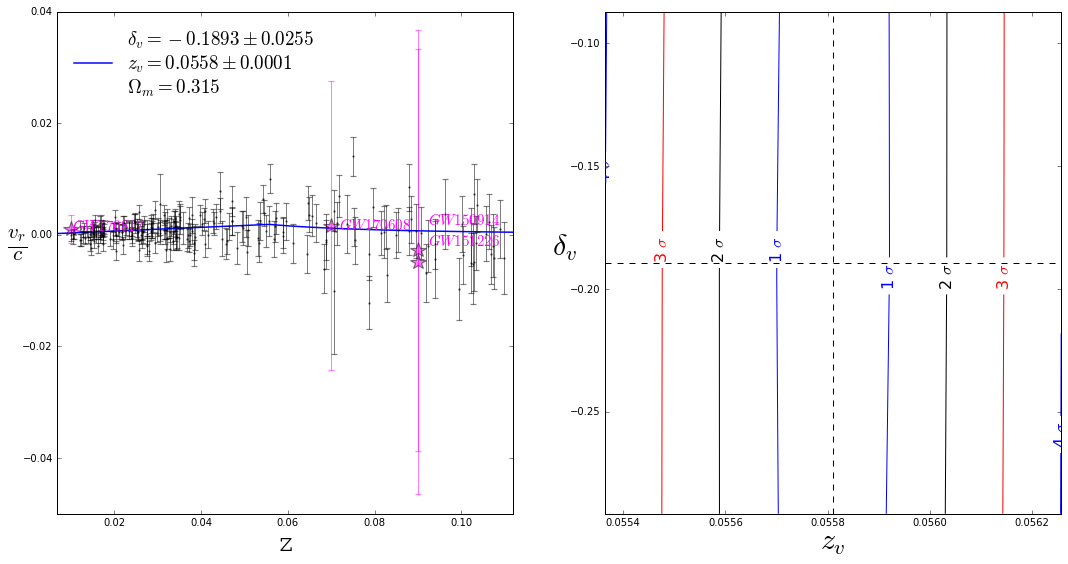

In [53]:
#Void
CFM_PP_ns = {'z1':{'color':'blue', 'marker':'-' },
             'z2':{'color':'blue', 'marker':'-'},
             'Eb':{'color':'black','marker':'o' , 'fmt':'o', 'markerfacecolor':'black'   },
             'Vl':{'color':'blue' },
             'EbGW':{'color':'magenta',  'marker':'*' , 'fmt':'o', 'markerfacecolor':'magenta'}
            }

contour_plot_dic_PP_ns = {'Fit' :results_PP_ns['Fit'],
                          'par1':results_PP_ns['Fit'].list_of_vary_param()[1],
                          'par2':results_PP_ns['Fit'].list_of_vary_param()[0],
    
            }

#text_plot_PP_ns    = {'x':0.08 , 'y':200 , 'text':'Fixed $\Omega_m$'}
#text_plot_PP_om_ns = {'x':0.08 , 'y':160 , 'text':'Varying $\Omega_m$' }

title_save = 'Pantheon_Planck_Void_velocity_without_shells'
fig=plt.figure(figsize=(18,9))
PlotFitData_zv(zs=z_pantheonP, mu=mu_pantheonP, muE=False, DE=DE_pantheonP, zsup=z_supPP, contour_plot_dic=contour_plot_dic_PP_ns, GW=GW_dic, dh=results_PP_ns['values']['dh'],    dhE=results_PP_ns['errors']['dh'],    zlim=results_PP_ns['values']['zlim'],    zlimE=results_PP_ns['errors']['zlim'],    H_Hubble=results_PP_ns['values']['H'],    O_m=results_PP_ns['values']['O_m'],    O_mE=results_PP_ns['errors']['O_m'],    H_2=0, H_error=H0_err, CFM=CFM_PP_ns,    text_plot=False, shells=False, shift=False, legend=True, v_line=False, figs=False, errorBar=True)
#PlotFitData_zv(zs=z_pantheonP, mu=mu_pantheonP, muE=muE_pantheonP, zsup=z_supPP, GW=False, dh=results_PP_om_ns['values']['dh'], dhE=results_PP_om_ns['errors']['dh'], zlim=results_PP_om_ns['values']['zlim'], zlimE=results_PP_om_ns['errors']['zlim'], H_Hubble=results_PP_om_ns['values']['H'], O_m=results_PP_om_ns['values']['O_m'], O_mE=results_PP_om_ns['errors']['O_m'], H_2=0, H_error=H0_err, CFM=CFM_PP_om_ns, text_plot=False, shells=False, shift=False, figs=False)
plt.savefig('/home/brayan/Documentos/Universidad/Proyecto_de_grado/Figures/Fit_V/%s'%title_save, bbox_inches='tight')
#plt.grid()

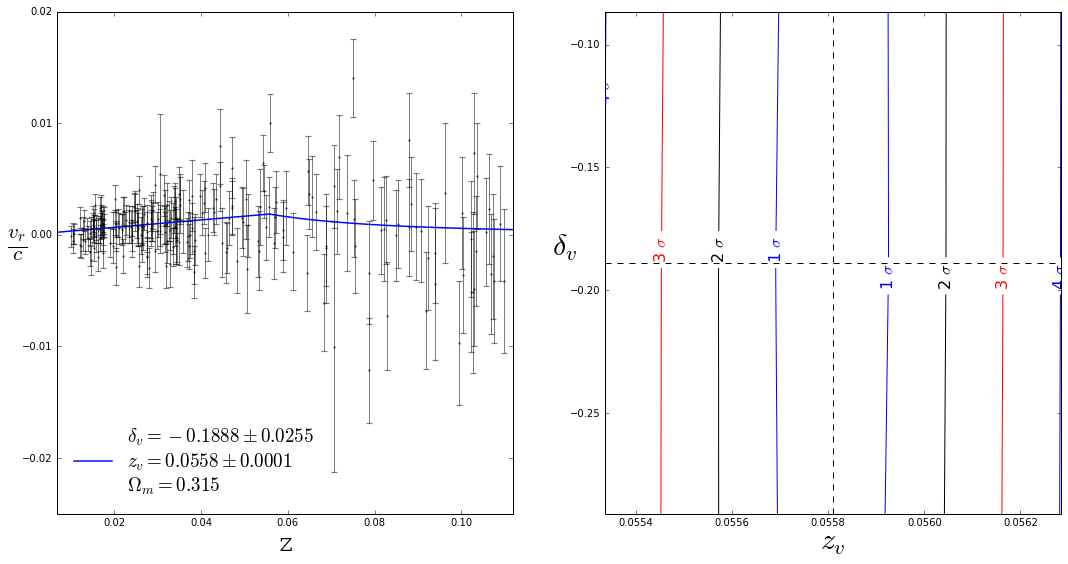

In [54]:
#Void no GW
CFM_PP_nGW_ns = {'z1':{'color':'blue', 'marker':'-' },
             'z2':{'color':'blue', 'marker':'-'},
             'Eb':{'color':'black','marker':'o' , 'fmt':'o', 'markerfacecolor':'black'   },
             'Vl':{'color':'blue' },
             'EbGW':{'color':'magenta',  'marker':'*' , 'fmt':'o', 'markerfacecolor':'magenta'}
            }

contour_plot_dic_PP_nGW_ns = {'Fit' :results_PP_nGW_ns['Fit'],
                              'par1':results_PP_nGW_ns['Fit'].list_of_vary_param()[1],
                              'par2':results_PP_nGW_ns['Fit'].list_of_vary_param()[0],
    
            }

#text_plot_PP_ns    = {'x':0.08 , 'y':200 , 'text':'Fixed $\Omega_m$'}
#text_plot_PP_om_ns = {'x':0.08 , 'y':160 , 'text':'Varying $\Omega_m$' }

title_save = 'Pantheon_Planck_Void_velocity_nGW_without_shells'
fig=plt.figure(figsize=(18,9))
PlotFitData_zv(zs=z_pantheonP, mu=mu_pantheonP, muE=False, DE=DE_pantheonP, zsup=z_supPP, contour_plot_dic=contour_plot_dic_PP_nGW_ns, GW=False, dh=results_PP_nGW_ns['values']['dh'],    dhE=results_PP_nGW_ns['errors']['dh'],    zlim=results_PP_nGW_ns['values']['zlim'],    zlimE=results_PP_nGW_ns['errors']['zlim'],    H_Hubble=results_PP_nGW_ns['values']['H'],    O_m=results_PP_nGW_ns['values']['O_m'],    O_mE=results_PP_nGW_ns['errors']['O_m'],    H_2=0, H_error=H0_err, CFM=CFM_PP_nGW_ns,    text_plot=False, shells=False, shift=False, legend=True, v_line=False, figs=False, errorBar=True)
#PlotFitData_zv(zs=z_pantheonP, mu=mu_pantheonP, muE=muE_pantheonP, zsup=z_supPP, GW=False, dh=results_PP_om_ns['values']['dh'], dhE=results_PP_om_ns['errors']['dh'], zlim=results_PP_om_ns['values']['zlim'], zlimE=results_PP_om_ns['errors']['zlim'], H_Hubble=results_PP_om_ns['values']['H'], O_m=results_PP_om_ns['values']['O_m'], O_mE=results_PP_om_ns['errors']['O_m'], H_2=0, H_error=H0_err, CFM=CFM_PP_om_ns, text_plot=False, shells=False, shift=False, figs=False)
plt.savefig('/home/brayan/Documentos/Universidad/Proyecto_de_grado/Figures/Fit_V/%s'%title_save, bbox_inches='tight')
#plt.grid()

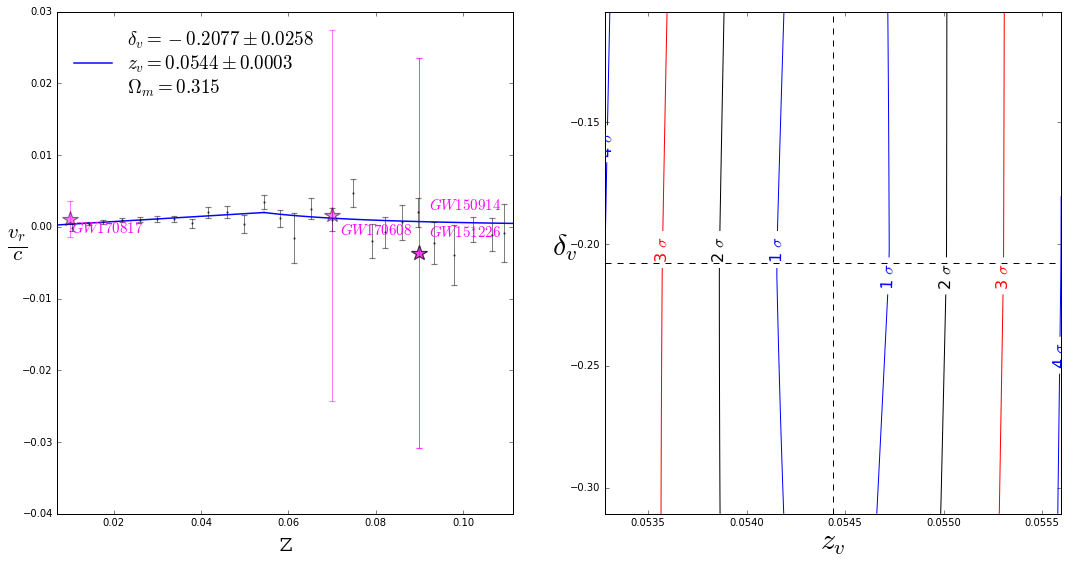

In [55]:
CFM_PP_s =  {'z1':{'color':'blue', 'marker':'-' },
             'z2':{'color':'blue', 'marker':'-'},
             'Eb':{'color':'black','marker':'o' , 'fmt':'o', 'markerfacecolor':'black'},
             'Vl':{'color':'blue' },
             'EbGW':{'color':'magenta',  'marker':'*' , 'fmt':'o', 'markerfacecolor':'magenta'}
            }

contour_plot_dic_PP_s  = {'Fit' :results_PP_s['Fit'],
                          'par1':results_PP_s['Fit'].list_of_vary_param()[1],
                          'par2':results_PP_s['Fit'].list_of_vary_param()[0],
    
            }

#text_plot_PP_ns    = {'x':0.08 , 'y':200 , 'text':'Fixed $\Omega_m$'}
#text_plot_PP_om_ns = {'x':0.08 , 'y':160 , 'text':'Varying $\Omega_m$' }

title_save = 'Pantheon_Planck_Void_velocity_with_shells'
fig=plt.figure(figsize=(18,9))
PlotFitData_zv(zs=z_pantheonP, mu=mu_pantheonP, muE=False, DE=DE_pantheonP, zsup=z_supPP, contour_plot_dic=contour_plot_dic_PP_s, GW=GW_dic, dh=results_PP_s['values']['dh'],    dhE=results_PP_s['errors']['dh'],    zlim=results_PP_s['values']['zlim'],    zlimE=results_PP_s['errors']['zlim'],    H_Hubble=results_PP_s['values']['H'],    O_m=results_PP_s['values']['O_m'],    O_mE=results_PP_s['errors']['O_m'],    H_2=0, H_error=H0_err, CFM=CFM_PP_s,    text_plot=False, shells=True, shift=False, legend=True, v_line=False, figs=False, errorBar=True)
#PlotFitData_zv(zs=z_pantheonP, mu=mu_pantheonP, muE=muE_pantheonP, zsup=z_supPP, GW=False, dh=results_PP_om_ns['values']['dh'], dhE=results_PP_om_ns['errors']['dh'], zlim=results_PP_om_ns['values']['zlim'], zlimE=results_PP_om_ns['errors']['zlim'], H_Hubble=results_PP_om_ns['values']['H'], O_m=results_PP_om_ns['values']['O_m'], O_mE=results_PP_om_ns['errors']['O_m'], H_2=0, H_error=H0_err, CFM=CFM_PP_om_ns, text_plot=False, shells=False, shift=False, figs=False)
plt.savefig('/home/brayan/Documentos/Universidad/Proyecto_de_grado/Figures/Fit_V/%s'%title_save, bbox_inches='tight')
#plt.grid()

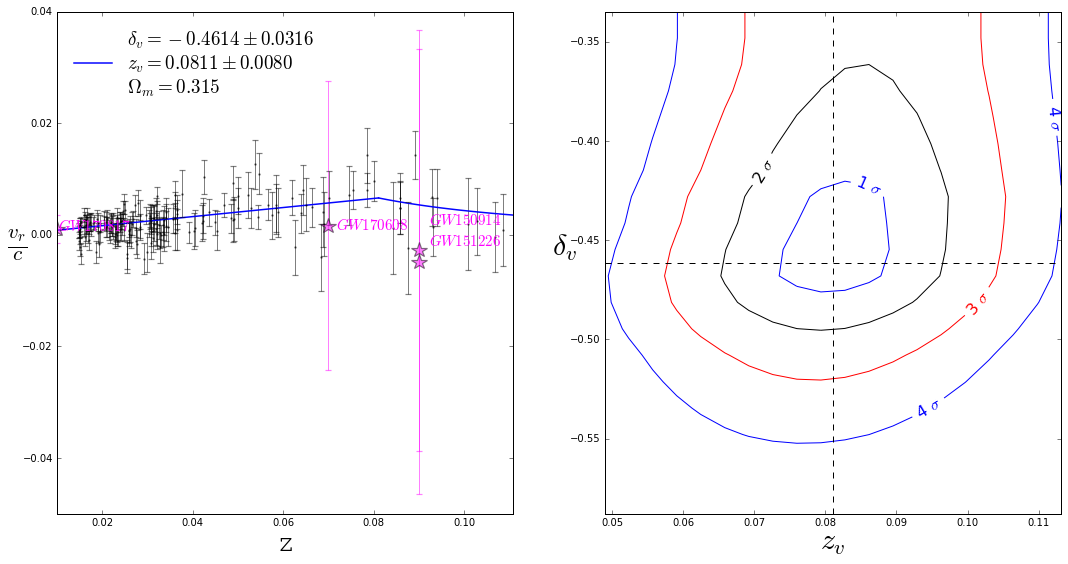

In [56]:
#Void
CFM_UP_ns = {'z1':{'color':'blue', 'marker':'-' },
             'z2':{'color':'blue', 'marker':'-'},
             'Eb':{'color':'black','marker':'o' , 'fmt':'bo', 'markerfacecolor':'black'   },
             'Vl':{'color':'blue' },
             'EbGW':{'color':'magenta',  'marker':'*', 'fmt':'o', 'markerfacecolor':'magenta'}
            }

contour_plot_dic_UP_ns = {'Fit' :results_UP_ns['Fit'],
                          'par1':results_UP_ns['Fit'].list_of_vary_param()[1],
                          'par2':results_UP_ns['Fit'].list_of_vary_param()[0],
    
            }

#text_plot_UP_ns    = {'x':0.085 , 'y':250 , 'text':'Fixed $\Omega_m$'}
#text_plot_UP_om_ns = {'x':0.085 , 'y':200 , 'text':'Varying $\Omega_m$' }

title_save = 'Union_Planck_Void_velocity_without_shells'
fig=plt.figure(figsize=(18,9))
PlotFitData_zv(zs=z_union_full, mu=mu_union_full, muE=muE_union_full, zsup=z_supUP,contour_plot_dic=contour_plot_dic_UP_ns ,GW=GW_dic, dh=results_UP_ns['values']['dh'],    dhE=results_UP_ns['errors']['dh'],    zlim=results_UP_ns['values']['zlim'],    zlimE=results_UP_ns['errors']['zlim'],    H_Hubble=results_UP_ns['values']['H'],    O_m=results_UP_ns['values']['O_m'],    O_mE=results_UP_ns['errors']['O_m'],    H_2=H0_Union, H_error=H0_err, CFM=CFM_UP_ns,    text_plot=False,    shells=False, shift=True, legend=True, v_line=False, figs=False, errorBar=True)
#PlotFitData_z(zs=z_union_full, mu=mu_union_full, muE=muE_union_full, zsup=z_supUP, dh=results_UP_om_ns['values']['dh'], dhE=results_UP_om_ns['errors']['dh'], zlim=results_UP_om_ns['values']['zlim'], zlimE=results_UP_om_ns['errors']['zlim'], H_Hubble=results_UP_om_ns['values']['H'], O_m=results_UP_om_ns['values']['O_m'], O_mE=results_UP_om_ns['errors']['O_m'], H_2=H0_Union, H_error=H0_err, CFM=CFM_UP_om_ns, text_plot=text_plot_UP_om_ns, shells=False, shift=True, figs=False)
plt.savefig('/home/brayan/Documentos/Universidad/Proyecto_de_grado/Figures/Fit_V/%s'%title_save, bbox_inches='tight')

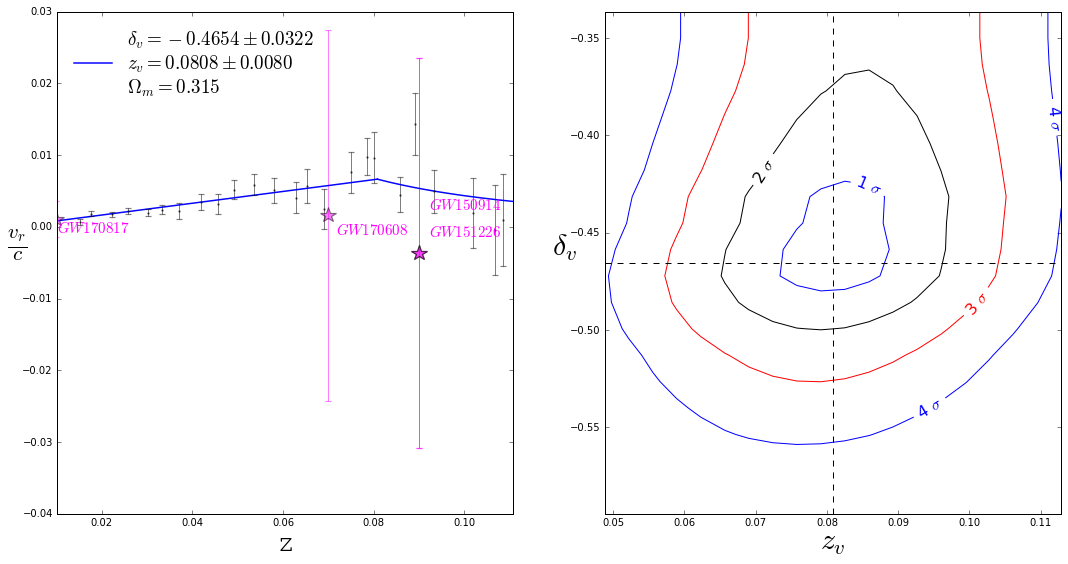

In [57]:
#Void
CFM_UP_s =  {'z1':{'color':'blue', 'marker':'-' },
             'z2':{'color':'blue', 'marker':'-'},
             'Eb':{'color':'black','marker':'o' , 'fmt':'bo', 'markerfacecolor':'black'   },
             'Vl':{'color':'blue' },
             'EbGW':{'color':'magenta',  'marker':'*' , 'fmt':'o', 'markerfacecolor':'magenta'}
            }


contour_plot_dic_UP_s =  {'Fit' :results_UP_s['Fit'],
                          'par1':results_UP_s['Fit'].list_of_vary_param()[1],
                          'par2':results_UP_s['Fit'].list_of_vary_param()[0],
    
            }

#text_plot_UP_s    = {'x':0.085 , 'y':250 , 'text':'Fixed $\Omega_m$'}
#text_plot_UP_om_s = {'x':0.085 , 'y':200 , 'text':'Varying $\Omega_m$' }

title_save = 'Union_Planck_Void_velocity_with_shells'
fig=plt.figure(figsize=(18,9))
PlotFitData_zv(zs=z_union_full, mu=mu_union_full, muE=muE_union_full, zsup=z_supUP, contour_plot_dic=contour_plot_dic_UP_s ,GW=GW_dic, dh=results_UP_s['values']['dh'],    dhE=results_UP_s['errors']['dh'],    zlim=results_UP_s['values']['zlim'],    zlimE=results_UP_s['errors']['zlim'],    H_Hubble=results_UP_s['values']['H'],    O_m=results_UP_s['values']['O_m'],    O_mE=results_UP_s['errors']['O_m'],    H_2=H0_Union, H_error=H0_err, CFM=CFM_UP_s,    text_plot=False,    shells=True, shift=True, legend=True, v_line=False, figs=False, errorBar=True)
#PlotFitData_z(zs=z_union_full, mu=mu_union_full, muE=muE_union_full, zsup=z_supUP, dh=results_UP_om_ns['values']['dh'], dhE=results_UP_om_ns['errors']['dh'], zlim=results_UP_om_ns['values']['zlim'], zlimE=results_UP_om_ns['errors']['zlim'], H_Hubble=results_UP_om_ns['values']['H'], O_m=results_UP_om_ns['values']['O_m'], O_mE=results_UP_om_ns['errors']['O_m'], H_2=H0_Union, H_error=H0_err, CFM=CFM_UP_om_ns, text_plot=text_plot_UP_om_ns, shells=False, shift=True, figs=False)
plt.savefig('/home/brayan/Documentos/Universidad/Proyecto_de_grado/Figures/Fit_V/%s'%title_save, bbox_inches='tight')